In [1]:
#  importlibraries
import pandas as pd
import numpy as np
import math

import glob  # identify file paths
#  the following two libraries needed to get .fit file contents from Training Peaks
import gzip  # decompress .gz files
from zipfile import ZipFile  # decompress .zip folders

#  import visualisation libraries
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns

# import sweat - a brilliant python library that is designd to make workout analysis a breeze!
import sweat as sw

In [2]:
#  read in excel file that is in same folder as this notebook - you can use the 'threshold_spreadsheet that I have it linked too. 
zone_df = pd.read_excel('threshold_spreadsheet.xlsx')

#  set bike thresholds for heart rate
bike_low_bpm = int(zone_df.iloc[:, 1][0])
bike_high_bpm = int(zone_df.iloc[:, 1][1])

#  set run thresholds for heart rate
run_low_bpm = int(zone_df.iloc[:, 2][0])
run_high_bpm = int(zone_df.iloc[:, 2][1])

# set general thresholds for heart rate
gen_low_bpm = int(zone_df.iloc[:, 3][0])
gen_high_bpm = int(zone_df.iloc[:, 3][1])

In [3]:
#  find all folder that end in .zip - Note: same location where ipynb notebook is
folders = glob.glob('*.zip')
#  select first folder name (you can alter if you have more than one folder - or create for loop)
folder = folders[0]

# Create a ZipFile Object and load Training Peaks .zip folder in it
with ZipFile(folder, 'r') as zipObj:
   # Extract all the contents of zip file into a 'data' folder.
   zipObj.extractall('data')

In [4]:
#  get all file names that were extracted from .zip folder
files = glob.glob('data/*.gz')

#  create empty list to put maximum session time - helps to format x-axis in the figure below
max_x_list = []


for file in files:
    with gzip.open(f'{file}', 'rb') as f:  # read in .gz file
        output = f.read()  # store contents of .fit file
        df = sw.read_fit(output, resample = True, interpolate = True)  # read in .fit file using sweat library - resample & interpolate both True
        df = df.reset_index(drop=False)  # resetting index of dataframe after resample & interpolation
        # convert time into secs and then hours and append to the empty list created above
        df['time_secs'] = (df['datetime'].dt.hour*60 + df['datetime'].dt.minute)* 60 + df['datetime'].dt.second       
        first_row = df['time_secs'].iloc[[0]].values[0]
        df['time'] = df['time_secs'].apply(lambda row: row - first_row)
        df['time'] = df['time'] / 3600
        max_x_list.append(df['time'].max())

max_x = pd.DataFrame(max_x_list)
max_x = math.ceil(max_x.max()) # .ceil - rounds number UP to nearest whole number 
print(max_x)

6


In [5]:
files = glob.glob('data/*.gz')  # get a list of file names that end in .gz

# define functions - for loop
#  function that reduces axs to N axes. All further axes are removed from the figure
#  this effectively ensures that there isn't an empty graph if the file number is odd
def trim_axs(axs, N):
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

num_plots = len(files)  # get number of total sessions for training block
rows = int(round(num_plots/2,0))  # get number of rows needed to organise figure

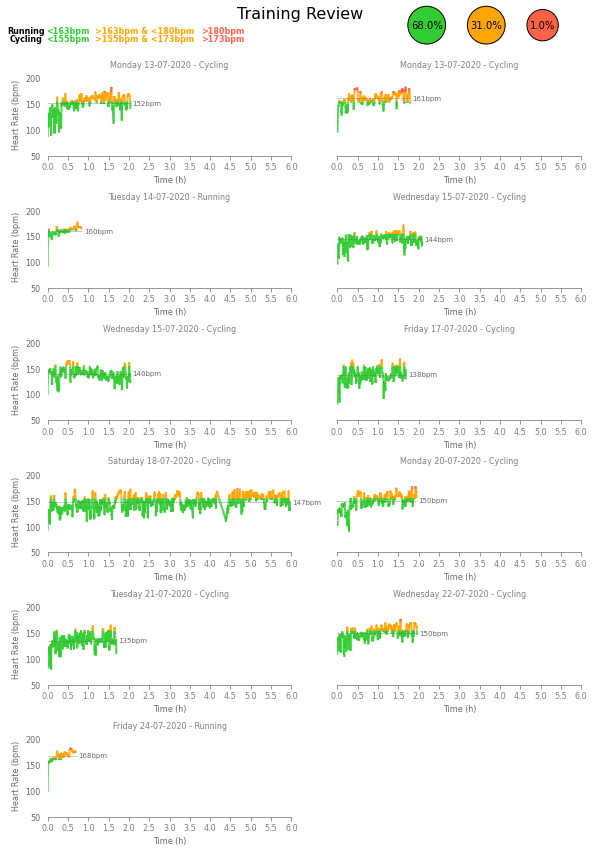

In [7]:
sport_list = []

fig, ax = plt.subplots(nrows=rows, ncols=2, figsize=(8.27, 11.69))  # set rows, columns and size (A4) for figure
axs = trim_axs(ax, len(files)) # use function to get number of necessary axs. 

fig.patch.set_facecolor('white')  # set figure colour as white

cycling_activities = ['Cycling', 'Indoor cycling', 'Bike']  # get a list of all potential cycle activities, depending on how Training Peaks defines
running_activities = ['Running', 'Run', 'Indoor running', 'Treadmill']   # get a list of all potential cycle activities, depending on how Training Peaks defines

#  create three emtpy lists for Zone 1, 2 & 3. Will be used to append time in zones for each session to create training distribution at the end. 
z1_list = []
z2_list = []
z3_list = []
    
for num, file in enumerate(files):
    with gzip.open(f'{file}', 'rb') as f:
        output = f.read()
        df = sw.read_fit(output, resample=True, interpolate=True)   # use sweat package to convert .fit to pandas DataFrame. Include resample & interpolation
        df = df.reset_index(drop=False)   # due to resample - reset the index of the dataframe
        df_sport = sw.read_fit(output)   # load in another dataframe without resample & interpolate - This is so we can get columns that contain string 
        sport = df_sport['sport'].iloc[[0]].values[0].capitalize()   # get activity name and capitalise
        sport_list.append(sport)   # append sport to list - will use list to show training zones of the different spors (run / bike / general)
        # this if statement sets lower and higher hr thresholds depending on the activity. 
        # this is using the varibles defined from the excel sheet 
        if sport in str(cycling_activities):
            low_hr = bike_low_bpm
            high_hr = bike_high_bpm
        elif sport in str(running_activities):
            low_hr = run_low_bpm
            high_hr = run_high_bpm 
        else:
            low_hr = gen_low_bpm
            high_hr = gen_high_bpm
        # as previous - next four lines get session time in hours 
        df['time'] = (df['datetime'].dt.hour*60 + df['datetime'].dt.minute)* 60 + df['datetime'].dt.second         
        first_row = df['time'].iloc[[0]].values[0]
        df['time'] = df['time'].apply(lambda row: row - first_row)
        df['time'] = df['time'] / 3600
        df['date'] = df['datetime'].dt.date
        date = df['date'].iloc[[0]].values[0]
        date = date.strftime("%A %d-%m-%Y")   # set date format - will be used in graph title 
        # counts the number of times 'True' that heart rate is either below, between or above thresholds defined 
        # appends count to list - Will be added too each time it loops through
        z1 = (df['heartrate'] < low_hr).sum()
        z1_list.append(z1)
        z2 = (df['heartrate'].between(low_hr,high_hr)).sum()
        z2_list.append(z2)
        z3 = (df['heartrate'] > high_hr).sum()
        z3_list.append(z3)
        # to provide graph with variables, they need to be in an array - time & heartrate given for X & Y, respectively. 
        x = np.array(df['time'])
        y = np.array(df['heartrate'])
        # get average heart rate for the sesion - then turn it to an integar. Use if/else as if heart rate is '0' (i.e. didnt record) 
        # it won't kick up error when converting to to integar
        ave_hr = round(y.mean(),0)
        if math.isnan(ave_hr):
            ave_hr = 0
        else:
            ave_hr = int(ave_hr)
        # reshapes both the X (time) & Y (heartrate) to get the individual points
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        # select colours for the three zones
        cmap = ListedColormap(['limegreen', 'orange', 'tomato'])
        # define boundaries for thresholds - needs a bottom (40 bpm) and top (210 bpm) as well as the two low/high heart rate thresholds. 
        norm = BoundaryNorm([40, low_hr, high_hr, 210], cmap.N)
        # create line collection of the different segments based on the boundaries
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        # set the array for the line collection, width of the line then add the collection to a chart. 
        lc.set_array(y)
        lc.set_linewidth(2)
        axs[num].add_collection(lc)
        axs[num].autoscale_view()
        # set title of chart - combining both the date and the sport
        axs[num].set_title(f'{date} - {sport}', color = 'grey', size = 8)
        axs[num].set_ylim(50,210)   # set the y axis limits
        axs[num].set_xlim(0,max_x)   # set the x axis limits - using the predefined max_x from the previous block of code
        axs[num].set_xlabel('Time (h)', color = 'dimgrey', size = 8)  # set x axis label 
        # the next if/else effectively only labels the y axis label if it is odd (the left hand graphs) - keeps the graph neat
        if (num % 2) == 0:
            axs[num].set_ylabel('Heart Rate (bpm)', color = 'dimgrey', size = 8)
            axs[num].tick_params(
            axis='y',          # changes apply to the y-axis
            colors = 'dimgrey',
            which='both',      # both major and minor ticks are affected
            left=False,
            right = False,     # ticks along the bottom edge are off       
            labelleft=True,
            labelsize=8)
        else:
            axs[num].tick_params(
            axis='y',          # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left=False,
            right = False,     # ticks along the bottom edge are off       
            labelleft=False,
            labelsize=8)
        # removes right, top and left chart borders but keeps bottom border
        axs[num].spines['right'].set_visible(False)
        axs[num].spines['top'].set_visible(False)
        axs[num].spines['left'].set_visible(False)
        axs[num].spines['bottom'].set_visible(True)
        axs[num].spines['bottom'].set_color('grey')
        # arrange the ticks - 0.5 h increments
        axs[num].set_xticks(np.arange(0,max_x+0.1,0.5))
        # add a horizontal line showing average heart rate for session & show value next to line
        axs[num].hlines(y=ave_hr, xmin = 0, xmax = x.max(), colors='dimgrey', linestyles='--', lw=0.5)
        axs[num].text(s=f'{ave_hr}bpm', x=x.max()+0.05, y=ave_hr, fontsize=7, ha='left', va='center', color = 'dimgrey')
        # set x-axis parameters
        axs[num].tick_params(
            axis='x',          # changes apply to the x-axis
            colors = 'grey',
            which='both',      # both major and minor ticks are affected
            bottom=True,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=True,
            labelsize=8)
        fig.tight_layout(pad=1.0)  # creates appropriate spacing between graphs

# title for visualisation
fig.text(s=f'Training Review', x=0.5, y=1.00, fontsize=16, ha='center', va='center')

# for loop takes all the different activities - Depending on activities in training phase, will display only the appropriate zones. 
sport_list = list(set(sport_list))
for sp_num, sport in enumerate(sport_list):
    fig.text(s=f'{sport}', x=0.04, y=1-(0.02+(sp_num/100)), fontsize=8, ha='center', va='center', color = 'black', weight='bold')
    if sport in cycling_activities:
        fig.text(s=f'<{bike_low_bpm}bpm', x=0.11, y=1-(0.02+(sp_num/100)), fontsize=8, ha='center', va='center', color = 'limegreen', weight='bold')
        fig.text(s=f'>{bike_low_bpm}bpm & <{bike_high_bpm}bpm', x=0.24, y=1-(0.02+(sp_num/100)), fontsize=8, ha='center', va='center', color = 'orange', weight='bold')
        fig.text(s=f'>{bike_high_bpm}bpm', x=0.37, y=1-(0.02+(sp_num/100)), fontsize=8, ha='center', va='center', color = 'tomato', weight='bold')
    elif sport in running_activities:
        fig.text(s=f'<{run_low_bpm}bpm', x=0.11, y=1-(0.02+(sp_num/100)), fontsize=8, ha='center', va='center', color = 'limegreen', weight='bold')
        fig.text(s=f'>{run_low_bpm}bpm & <{run_high_bpm}bpm', x=0.24, y=1-(0.02+(sp_num/100)), fontsize=8, ha='center', va='center', color = 'orange', weight='bold')
        fig.text(s=f'>{run_high_bpm}bpm', x=0.37, y=1-(0.02+(sp_num/100)), fontsize=8, ha='center', va='center', color = 'tomato', weight='bold')
    else:
        fig.text(s=f'<{gen_low_bpm}bpm', x=0.11, y=1-(0.02+(sp_num/100)), fontsize=8, ha='center', va='center', color = 'limegreen', weight='bold')
        fig.text(s=f'>{gen_low_bpm}bpm & <{gen_high_bpm}bpm', x=0.24, y=1-(0.02+(sp_num/100)), fontsize=8, ha='center', va='center', color = 'orange', weight='bold')
        fig.text(s=f'>{gen_high_bpm}bpm', x=0.37, y=1-(0.02+(sp_num/100)), fontsize=8, ha='center', va='center', color = 'tomato', weight='bold')

# calculates % total time in Zone 1, 2 & 3 
total_zone = sum(z1_list) + sum(z2_list) + sum(z3_list)
z1 = round((sum(z1_list)/total_zone)*100,0)
z2 = round((sum(z2_list)/total_zone)*100,0)
z3 = round((sum(z3_list)/total_zone)*100,0)

# visualise the three training zones in coloured circles
plt.annotate(f"{z1}%", xy = (0.69, 0.98), xycoords = "figure fraction", bbox = dict(boxstyle = "circle", fc = "limegreen"))  
plt.annotate(f"{z2}%", xy = (0.79, 0.98), xycoords = "figure fraction", bbox = dict(boxstyle = "circle", fc = "orange"))  
plt.annotate(f"{z3}%", xy = (0.89, 0.98), xycoords = "figure fraction", bbox = dict(boxstyle = "circle", fc = "tomato"))   

# adjust subplots down - allowing space for training zones and distribution visualisations
plt.subplots_adjust(top=0.93)

# export figure as pdf - can also change to .png if you want as image
fig.savefig('Training_Review.png', bbox_inches='tight')